# LAB 4.2 - Transfer learning

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

replicating local resources


In [63]:
from local.lib.rlxmoocapi import submit, session
student = session.Session(init.endpoint).login( course_id=init.course_id, lab_id="L04.02" )

username: davida.torres@udea.edu.co
password: ··········
using session UDEA


<big><font color="red">BE PATIENT IN THIS LAB, MODELS ARE LARGE AND MAY TAKE A WHILE TO DOWNLOAD, TRAIN, MAKE INFERENCE, and ALSO FOR GRADERS TO EVALUATE YOUR SUBMISSION.</font></big>

You may want to set the runtime to GPU if in Google Colab

In [2]:
import tensorflow as tf
!pip install --upgrade tensorflow_hub

import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import h5py
import pandas as pd

%matplotlib inline

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.7/dist-packages (0.12.0)


## TASK 1: `tensorflow hub` classification model

Complete the following function so that it uses the [Inception V1 model on `tensorflow hub`](https://tfhub.dev/google/imagenet/inception_v1/classification/4) to obtain the three top ImageNet labels for a given image, along with their probabilities. Observe that:

- the input `img` is an `np.array` of dims `[w,h,3]`
- the model returns `logits` which must be transformed into probabilities with a softmax function: $p_i = \frac{e^{L_i}}{\sum_j e^{L_j}}$, where $p_i$ is the probability of class $i$ and $L_i$ is the `logit` assigned to that class
- you must **resize** the input `img` to dimensions `[1,224,224,3]`. Use [`skimage.transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) with `anti_aliasing=True`.
- you must ensure the **pixel values** of `img` are in the `[0,1]` range. Normalize the image pixel values by substracting the minimum value and dividing by the difference between the maximum and the minimum.
- the logits returned by the model correspond to the labels in [this file](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt) as described in the tensorflob hub model page. This list is passed to your function in the `labels_list` argument.
- you **must return** a dictionary with three elements, containing the class labels as keys and the probabilities as values.

For instance, for the following image you should return this dictionary:

      {'king snake': 0.8190326,
       'ringneck snake': 0.026169779,
       'sea snake': 0.030096276}


    

(382, 660, 3)

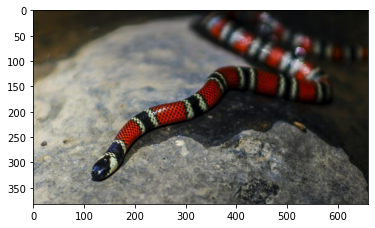

In [3]:
snake_img = imread('local/imgs/snake.jpg')
plt.imshow(snake_img)
snake_img.shape

In [9]:
with open("local/data/ImageNetLabels.txt", "r") as f:
    labels_list = [i.rstrip() for i in f.readlines()]

def get_top3_inceptionv1_labels(img, labels_list):

    from skimage.transform import resize

    m = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/5") ])    # load the tensorflow hub model
    m.build([None, 224, 224, 3])  # Batch input shape.
    machetazo =np.zeros((1,224,224,3))
    machetazo[0,:,:,:] =  resize( image = img , output_shape = [224,224,3], anti_aliasing = True )   # resize and reshape the image to [1,224,224,3] 
    machetazo[0,:,:,:] = (machetazo[0,:,:,:]-np.min(machetazo[0,:,:,:]))/(np.max(machetazo[0,:,:,:])-np.min(machetazo[0,:,:,:]))  # normalize the image to a [0,1] range
    logits =   m.predict(machetazo)  # feed the image into the model to obtain the logits 
    expon = np.exp(logits) ;
    probs  = expon/expon.sum()  # convert logits to probabilities
    idxs = np.argsort(-probs)[0,:3]
    r = {}
    for i in idxs:
      r[labels_list[i]] = probs[0,i];
    return r

check your code with the image above

In [10]:
get_top3_inceptionv1_labels(snake_img, labels_list)

{'king snake': 0.81903285,
 'ringneck snake': 0.026169773,
 'sea snake': 0.03009623}

check your code with any image available on the internet

{'chimpanzee': 0.9627988,
 'gorilla': 0.0013446779,
 'hippopotamus': 0.0016488603}

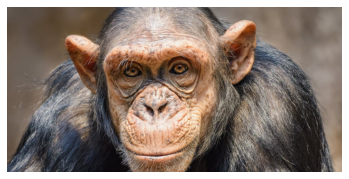

In [11]:
url_chimp = 'https://scx2.b-cdn.net/gfx/news/2019/canwereallyk.jpg'
!wget -q -O img.jpg $url_chimp
img = imread('img.jpg')
plt.imshow(img); plt.axis("off")
get_top3_inceptionv1_labels(img, labels_list)

**Registra tu solución en linea**

In [12]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: `tensorflow hub` feature extraction model

complete the following function such that when given a set of images returns the feature vectors extracted for each image with the [InceptionV1](https://tfhub.dev/google/imagenet/inception_v1/feature_vector/4) `tensorflow hub` model.

Observe that:

- `tensorflow hub` publishes a different model service for classification or for feature extraction
- `imgs` can be any array of shape `[n_images, w, h, n_channels]`
- the output must be of shape `[n_images, 1024]`
- you must return a `numpy` array

In [13]:
!wget -nc -q https://s3.amazonaws.com/rlx/mini_cifar.h5
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
x_cifar.shape, y_cifar.shape

((1000, 32, 32, 3), (1000,))

In [19]:
def feature_vector_inceptionv1(imgs):

    m = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5",
                      trainable=False)
    ])
    m.build([None, 224, 224, 3])  # Batch input shape.

    return m.predict(imgs)

observe we can extract the features of our mini cifar dataset

In [21]:
xf_cifar = feature_vector_inceptionv1(x_cifar)
xf_cifar.shape

(1000, 1024)

check your code, this sum must be close to:

      array([186.98825, 436.80975, 237.31288, 353.58902, 492.95978, 307.38007,
            234.02158, 260.64508, 186.74268, 265.00177], dtype=float32)

In [22]:
xf_cifar.sum(axis=1)[:10]

array([186.98848, 436.80994, 237.31305, 353.5894 , 492.95963, 307.38   ,
       234.02153, 260.6449 , 186.74269, 265.0018 ], dtype=float32)

observe we can do many things now with the features such as

- compute similarity between images in this feature space
- use any classical machine learning method
- etc.

similarity in feature space 26.467068


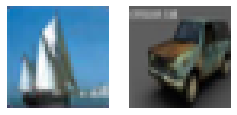

In [24]:
i,j = np.random.randint(len(xf_cifar), size=2)
imgA, imgB = x_cifar[i], x_cifar[j]
plt.figure(figsize=(4,2))
plt.subplot(121); plt.imshow(imgA); plt.axis("off")
plt.subplot(122); plt.imshow(imgB); plt.axis("off");
print ("similarity in feature space", np.linalg.norm(xf_cifar[i]-xf_cifar[j]))

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

estimator = SVC(gamma=.001)
cross_val_score(estimator, xf_cifar, y_cifar)

array([0.755, 0.73 , 0.775, 0.765, 0.73 ])

**Registra tu solución en linea**

In [28]:
student.submit_task(namespace=globals(), task_id='T2');

## TASK 3: Model for fine tuning

Complete the following function so that it builds a model with three layers:

- one `hub.KerasLayer` with [https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1](https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1) feature vector extraction and `trainable` according to the function parameter.
- one `Dense` layer with `dense_size` neurons and `relu` activation
- one `Dense` layer as output with 3 neurons (one for each class) and `softmax` activation

In [58]:
def create_model(trainable=False, dense_size=100):
    num_classes = 3
    m = tf.keras.Sequential([
      hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
                      trainable=trainable),  # Can be True, see below.
          tf.keras.layers.Dense(dense_size, activation=tf.nn.relu),
          tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
    ])
    
    return m

with `dense_size=100` and `input_shape=[None, 32, 32, 3]` your model should have a total of `64,354,083` parameters, with only  `256,403` trainable params if `trainable=False`, and `64,043,363` if `trainable=True`

In [59]:
m = create_model(trainable=True)
m.build(input_shape=[None, 32, 32, 3])
m.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_21 (KerasLayer)  (None, 2560)              64097680  
_________________________________________________________________
dense_17 (Dense)             (None, 100)               256100    
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 303       
Total params: 64,354,083
Trainable params: 64,043,363
Non-trainable params: 310,720
_________________________________________________________________


you can now train your model. If you set `trainable=True` you should get >80% accuracy in validation with 10-30 epochs

In [60]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)


In [65]:
m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
m.fit(x_train, y_train, epochs=10,batch_size=16, validation_data=(x_test, y_test))

Epoch 1/10
50/50 [==============================] - 65s 266ms/step - loss: 2.0107 - accuracy: 0.3658 - val_loss: 1.7299 - val_accuracy: 0.2900
Epoch 2/10
50/50 [==============================] - 8s 166ms/step - loss: 1.5616 - accuracy: 0.5175 - val_loss: 1.9738 - val_accuracy: 0.5150
Epoch 3/10
50/50 [==============================] - 8s 167ms/step - loss: 1.3748 - accuracy: 0.5210 - val_loss: 1.1369 - val_accuracy: 0.6300
Epoch 4/10
50/50 [==============================] - 9s 171ms/step - loss: 1.1391 - accuracy: 0.6741 - val_loss: 1.2666 - val_accuracy: 0.7300
Epoch 5/10
50/50 [==============================] - 8s 170ms/step - loss: 1.0741 - accuracy: 0.7321 - val_loss: 1.1612 - val_accuracy: 0.7250
Epoch 6/10
50/50 [==============================] - 8s 169ms/step - loss: 0.9542 - accuracy: 0.7881 - val_loss: 1.0261 - val_accuracy: 0.7750
Epoch 7/10
50/50 [==============================] - 8s 168ms/step - loss: 0.8968 - accuracy: 0.8051 - val_loss: 1.0762 - val_accuracy: 0.7650
Epoch

**Registra tu solución en linea**

In [64]:
student.submit_task(namespace=globals(), task_id='T3');